# Asteroid Light Curve Examples - Part 1

This notebook contains examples deep learning techniques applied to the asteroid light curve data from http://alcdef.org.


# Objectives
- Understand when a convolutional neural network (CNN) might be applicable.
- See how to apply a 1D-CNN to time-series data.
- See how to build a more complex model that takes both time-series and categorical inputs.

# Parameters

In [1]:
# Path to the ALCDEF_ALL dataset downloaded from http://alcdef.org
# Download the full archive as a .zip file. Extract its contents to this
# directory. It should be ~14K .txt files.
data_dir = 'data/ALCDEF_ALL'

# Discard any light curves with fewer than this many samples
min_samples = 100

# Resample light curves to common number of samples
nb_samples = 100

# Discard any light curve that isn't among the nb_classes most common objects
nb_classes = 20

# Imports

In [26]:
%matplotlib inline
import matplotlib.pyplot as plt

import numpy as np
from glob import glob
from scipy.signal import resample
from collections import Counter

import random

from keras.models import Sequential, Model
from keras.layers import Dense, Dropout, LSTM
from keras.utils import to_categorical
from keras.optimizers import SGD, Adam
from keras import regularizers
from keras.callbacks import EarlyStopping
from keras.layers import Conv1D, MaxPooling1D, Flatten, GlobalAveragePooling1D, Input, concatenate

from sklearn.metrics import confusion_matrix
from sklearn.model_selection import train_test_split

from sklearn.manifold import TSNE
from sklearn.decomposition import PCA
import umap

import pandas as pd
import seaborn as sns

from ml4ssa_utils import visualize_embedding, load_alcdef_data, plot_alcdef_examples, normalize_features, plot_confusion_matrix

# Load Dataset

Load data from Astroid Lightcurve Photometry Database (http://alcdef.org/)

In [3]:
data = load_alcdef_data(
    data_dir=data_dir,
    min_samples=min_samples,
    resample_to=nb_samples,
    reduce_to_top=nb_classes
)

In [4]:
# Gather a list of the object names we'll be working with
names = list(set([item['OBJECTNAME'] for item in data]))

# Visualize Examples

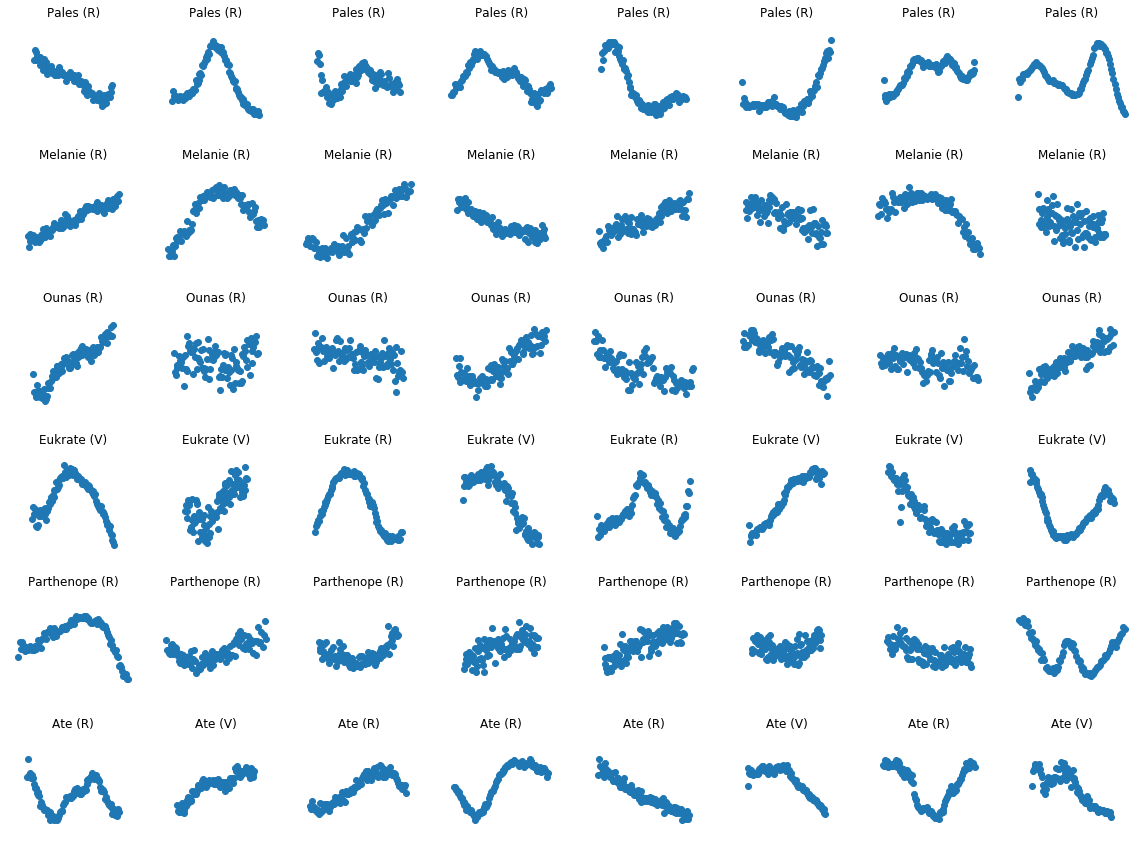

In [5]:
plot_alcdef_examples(data)

# Generate Train and Test Data Sets

In [6]:
X = np.array([ item['DATA_RESAMPLED'][:,1] for item in data ])
y = np.array([ names.index(item['OBJECTNAME']) for item in data ])

# Reserve 20% of the data for testing
# Startify the data split so that the train and test sets have the same class distribution
X_train, X_test, y_train, y_test, data_train, data_test = train_test_split(X, y, data, test_size=0.20, stratify=y)

print('Generated train and test sets with the following sizes:')
print('Train X (features) {}, y (targets) {}'.format(X_train.shape, y_train.shape))
print('Test  X (features) {}, y (targets) {}'.format(X_test.shape, y_test.shape))

Generated train and test sets with the following sizes:
Train X (features) (615, 100), y (targets) (615,)
Test  X (features) (154, 100), y (targets) (154,)


## Review Class Distributions to Understand Performance of Random Classifier

It's always helpful to understand how well a random classifier should perform. This sets a worst case baseline. If you're doing better than this performance, you know at least something is working. If your classifier is performing worse than random, something is broken. If it's performing at the same level as random, it's either broken or you have a very hard problem (at least with your current size and distribution of training data).

In [7]:
class_counts = np.sum(to_categorical(y_test), axis=0)
class_proportions = class_counts / np.sum(class_counts)
max_proportion = np.max(class_proportions)
random_performance = 1./nb_classes

print('Random Performance: {:.3f}'.format(1./nb_classes))
print('Mode Collapse Performance: {:.3f}'.format(max_proportion))
print('-'*65)
for name, proportion in zip(names, class_proportions):
    print('{:15} {:.3f} {}'.format(name, proportion, 'largest' if proportion == max_proportion else ''))

Random Performance: 0.050
Mode Collapse Performance: 0.110
-----------------------------------------------------------------
Eudora          0.052 
Euterpe         0.039 
Pales           0.039 
Aline           0.039 
Aurelia         0.039 
Scania          0.045 
Parthenope      0.104 
Zelinda         0.058 
Cupido          0.045 
Eukrate         0.039 
Thora           0.039 
Ate             0.058 
Lachesis        0.039 
Ganymed         0.110 largest
Ounas           0.039 
Polyhymnia      0.039 
Norma           0.039 
Melanie         0.045 
Leukothea       0.052 
Philia          0.039 


# Try an MLP (multi-layer perceptron) similiar to the TLE Example

In [8]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Dense(units=100,activation='relu', input_shape=(100,)))
model.add(Dense(units=100, activation='relu'))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='sgd',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
# model.predict(np.zeros((16,9)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
dense_1 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_2 (Dense)              (None, 100)               10100     
_________________________________________________________________
dense_3 (Dense)              (None, 20)                2020      
Total params: 22,220
Trainable params: 22,220
Non-trainable params: 0
_________________________________________________________________


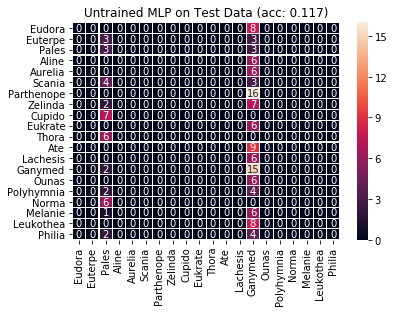

In [9]:
plot_confusion_matrix(model, X_test, y_test, 'Untrained MLP on Test Data', names=names)

In [10]:
# Prepare data to pass to model
repeats = 100
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X_train.repeat(repeats, axis=0))
train_targets = to_categorical(y_train.repeat(repeats, axis=0))
test_features = normalize_features(X_test)
test_targets = to_categorical(y_test)

# Fit model to data
model.fit(
    train_features, train_targets,
    validation_data=(test_features, test_targets),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=3, monitor='val_loss')],
    verbose=1
)

Train on 61500 samples, validate on 154 samples
Epoch 1/10
61500/61500 [==============================] - 3s 46us/step - loss: 2.4625 - acc: 0.1685 - val_loss: 2.4192 - val_acc: 0.1883
Epoch 2/10
61500/61500 [==============================] - 3s 44us/step - loss: 2.2957 - acc: 0.2025 - val_loss: 2.3459 - val_acc: 0.1558
Epoch 3/10
61500/61500 [==============================] - 3s 45us/step - loss: 2.2504 - acc: 0.2100 - val_loss: 2.3178 - val_acc: 0.1558
Epoch 4/10
61500/61500 [==============================] - 3s 45us/step - loss: 2.2119 - acc: 0.2255 - val_loss: 2.2903 - val_acc: 0.2208
Epoch 5/10
61500/61500 [==============================] - 3s 44us/step - loss: 2.1725 - acc: 0.2487 - val_loss: 2.2792 - val_acc: 0.2532
Epoch 6/10
61500/61500 [==============================] - 3s 45us/step - loss: 2.1403 - acc: 0.2618 - val_loss: 2.2813 - val_acc: 0.2403
Epoch 7/10
61500/61500 [==============================] - 3s 51us/step - loss: 2.1175 - acc: 0.2684 - val_loss: 2.2454 - val_acc: 

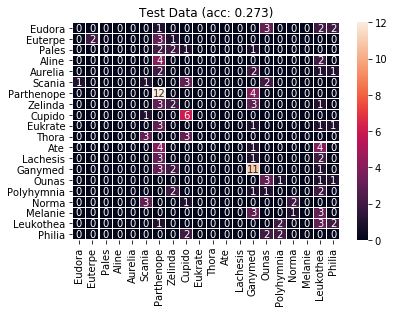

In [11]:
plot_confusion_matrix(model, X_test, y_test, 'Test Data', names=names)

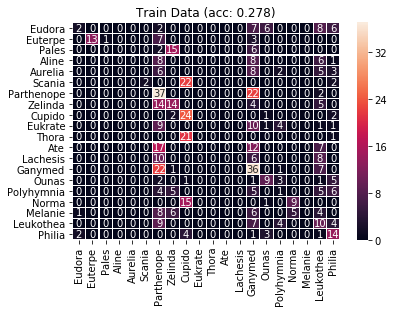

In [12]:
plot_confusion_matrix(model, X_train, y_train, 'Train Data', names=names)

# CNN Model

Now that we have two baselines (random performance and the MLP we used for TLE data), let's look at improving our performance with a different model.

In [13]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=64, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=32, kernel_size=5, activation='relu'))
model.add(MaxPooling1D())
model.add(Conv1D(filters=16, kernel_size=5, activation='relu'))
model.add(GlobalAveragePooling1D())
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_1 (Conv1D)            (None, 96, 64)            384       
_________________________________________________________________
max_pooling1d_1 (MaxPooling1 (None, 48, 64)            0         
_________________________________________________________________
conv1d_2 (Conv1D)            (None, 44, 32)            10272     
_________________________________________________________________
max_pooling1d_2 (MaxPooling1 (None, 22, 32)            0         
_________________________________________________________________
conv1d_3 (Conv1D)            (None, 18, 16)            2576      
_________________________________________________________________
global_average_pooling1d_1 ( (None, 16)                0         
_________________________________________________________________
dense_4 (Dense)              (None, 20)                340       
Total para

In [14]:
# Prepare data to pass to model
repeats = 100
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X_train.repeat(repeats, axis=0))
train_targets = to_categorical(y_train.repeat(repeats, axis=0))
test_features = normalize_features(X_test)
test_targets = to_categorical(y_test)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)
test_features = np.expand_dims(test_features, axis=-1)

model.fit(
    train_features, train_targets,
    validation_data=(test_features, test_targets),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss')],
    verbose=1
)

Train on 61500 samples, validate on 154 samples
Epoch 1/10
61500/61500 [==============================] - 1090s 18ms/step - loss: 2.2010 - acc: 0.2361 - val_loss: 2.2053 - val_acc: 0.2143
Epoch 2/10
61500/61500 [==============================] - 1129s 18ms/step - loss: 2.0066 - acc: 0.2917 - val_loss: 2.2793 - val_acc: 0.2078
Epoch 3/10
61500/61500 [==============================] - 1184s 19ms/step - loss: 1.9634 - acc: 0.3049 - val_loss: 2.4039 - val_acc: 0.2273
Epoch 4/10
61500/61500 [==============================] - 1178s 19ms/step - loss: 1.9344 - acc: 0.3122 - val_loss: 2.2558 - val_acc: 0.2143
Epoch 5/10
61500/61500 [==============================] - 1186s 19ms/step - loss: 1.9140 - acc: 0.3167 - val_loss: 2.4238 - val_acc: 0.2208
Epoch 6/10
61500/61500 [==============================] - 1181s 19ms/step - loss: 1.9041 - acc: 0.3178 - val_loss: 2.6379 - val_acc: 0.2078


# Light Curve Embedding Based on Extracted Features

In [15]:
# Here we extract the intermediate features/activations from the layer named penultimate
layer_name = 'penultimate'
intermediate_layer_model = Model(inputs=model.input, outputs=model.layers[-2].output)
X_penultimate_test = intermediate_layer_model.predict(test_features)

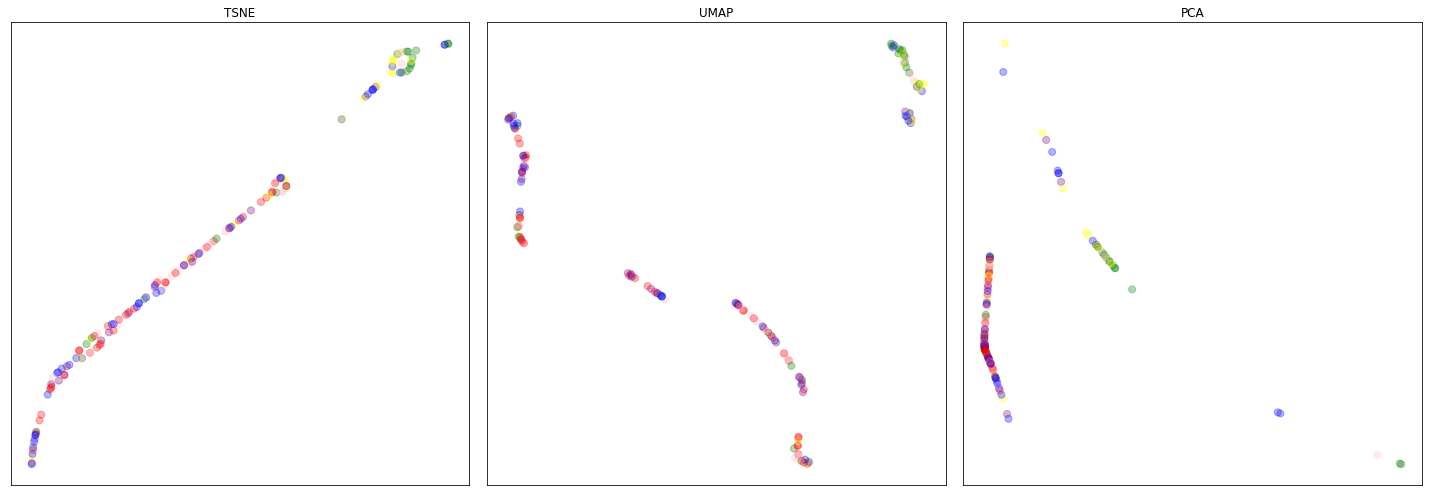

In [16]:
visualize_embedding(X_penultimate_test, y_test)

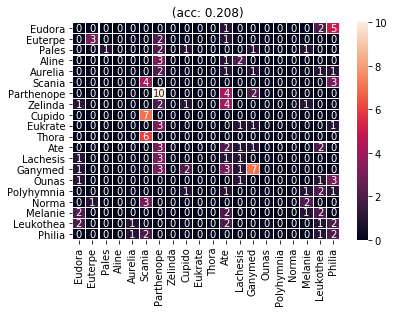

In [19]:
plot_confusion_matrix(model, test_features, y_test, '', names=names)

# Multi-Modal Input

The above models use features from single modality (sampled light curves). In real world problems, we often have multiple data types that will be relevant to our problem. For exampoe, we typically at least have metadata associated with sampled data.

The convolutional layers were motivated by the assumption that our sampled data was translationally invariant. As we have no reason to believe this should be the case for our metadata (it's not even clear what that would mean), we'll need to think about how best to incorporate additional data.

In [20]:
def generate_metadata_vector(item):
    '''Generate a metadata vector of the form <one-hot-encoded filter value> | <phase>.
    
    The data appears to have 3 different filter codes and a single phase value so the metadata vector
    will be of length 4.
    '''
    v = np.zeros(4)
    filter_codes = ['V', 'R', 'C']
    filter_ndx = filter_codes.index(item['FILTER'])
    v[filter_ndx] = 1
    v[-1] = float(item['PHASE']) / 60. # 60 was chosen as it was the largest value observed in a chunk of the data
    return v

In [23]:
metric='acc'

nb_classes = len(names)

nb_metadata_inputs = 4

cnn_input = Input(shape=(nb_samples,1), name='cnn_input')
x = Conv1D(filters=64, kernel_size=5, activation='relu')(cnn_input)
x = MaxPooling1D()(x)
x = Conv1D(filters=32, kernel_size=5, activation='relu')(x)
x = MaxPooling1D()(x)
x = Conv1D(filters=16, kernel_size=5, activation='relu')(x)
cnn_output = GlobalAveragePooling1D()(x)

metadata_input = Input(shape=(nb_metadata_inputs,), name='metadata_input')
x = Dense(units=10, activation='relu')(metadata_input)
metadata_output = Dense(units=10, activation='relu')(x)

merged = concatenate([cnn_output, metadata_output])

final_output = Dense(units=nb_classes, activation='softmax')(merged)

model = Model([cnn_input, metadata_input], final_output)

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[metric]
)

model.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
cnn_input (InputLayer)          (None, 100, 1)       0                                            
__________________________________________________________________________________________________
conv1d_7 (Conv1D)               (None, 96, 64)       384         cnn_input[0][0]                  
__________________________________________________________________________________________________
max_pooling1d_5 (MaxPooling1D)  (None, 48, 64)       0           conv1d_7[0][0]                   
__________________________________________________________________________________________________
conv1d_8 (Conv1D)               (None, 44, 32)       10272       max_pooling1d_5[0][0]            
__________________________________________________________________________________________________
max_poolin

In [25]:
# Prepare data to pass to model
repeats = 10
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X_train.repeat(repeats, axis=0))
train_targets = to_categorical(y_train.repeat(repeats, axis=0))
test_features = normalize_features(X_test)
test_targets = to_categorical(y_test)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)
test_features = np.expand_dims(test_features, axis=-1)

# Generate the metadata features
train_metadata_features = np.stack([ generate_metadata_vector(item) for item in data_train ]).repeat(repeats, axis=0)
test_metadata_features = np.stack([ generate_metadata_vector(item) for item in data_test ])

model.fit(
    [train_features, train_metadata_features], train_targets,
    validation_data=([test_features, test_metadata_features], test_targets),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss')],
    verbose=1
)

Train on 6150 samples, validate on 154 samples
Epoch 1/10
6150/6150 [==============================] - 115s 19ms/step - loss: 2.4147 - acc: 0.2434 - val_loss: 2.1445 - val_acc: 0.3182
Epoch 2/10
6150/6150 [==============================] - 111s 18ms/step - loss: 1.9617 - acc: 0.3660 - val_loss: 1.9389 - val_acc: 0.3896
Epoch 3/10
6150/6150 [==============================] - 112s 18ms/step - loss: 1.7892 - acc: 0.4106 - val_loss: 1.8477 - val_acc: 0.4026
Epoch 4/10
6150/6150 [==============================] - 111s 18ms/step - loss: 1.6687 - acc: 0.4320 - val_loss: 1.8205 - val_acc: 0.3701
Epoch 5/10
6150/6150 [==============================] - 118s 19ms/step - loss: 1.5877 - acc: 0.4421 - val_loss: 1.7468 - val_acc: 0.4091
Epoch 6/10
6150/6150 [==============================] - 112s 18ms/step - loss: 1.5243 - acc: 0.4698 - val_loss: 1.7314 - val_acc: 0.4221
Epoch 7/10
6150/6150 [==============================] - 111s 18ms/step - loss: 1.4681 - acc: 0.4928 - val_loss: 1.7473 - val_acc: 0

# Recurrent Neural Network

A CNN processes an entire sequence of data in one step. An RNN, on other hand, processes sequences an element at a time. At each time step, it has access to the current sequence element and whatever information it might have extracted from the preceeding elements.

In [27]:
metric='acc'

nb_classes = len(names)

model = Sequential()
model.add(Conv1D(filters=16, kernel_size=5, activation='relu', padding='same'))
model.add(LSTM(16, return_sequences=True))
model.add(LSTM(16, return_sequences=False))
model.add(Dense(units=nb_classes, activation='softmax'))

model.compile(
    loss='categorical_crossentropy',
    optimizer='adam',
    metrics=[metric]
)

# keras is complaining that I need to evaluate the model before printing a summary
model.predict(np.zeros((16,100,1)))

model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv1d_10 (Conv1D)           (None, 100, 16)           96        
_________________________________________________________________
lstm_1 (LSTM)                (None, 100, 16)           2112      
_________________________________________________________________
lstm_2 (LSTM)                (None, 16)                2112      
_________________________________________________________________
dense_10 (Dense)             (None, 20)                340       
Total params: 4,660
Trainable params: 4,660
Non-trainable params: 0
_________________________________________________________________


In [29]:
# Prepare data to pass to model
repeats = 10
# The repeats value here is used to artifically increase the size of our training set.
# This forces keras to treat <repeats> passes through the training set as a single epoch and we
# get to avoid a huge number of progress bars and short-term variance in metrics.
train_features = normalize_features(X_train.repeat(repeats, axis=0))
train_targets = to_categorical(y_train.repeat(repeats, axis=0))
test_features = normalize_features(X_test)
test_targets = to_categorical(y_test)

# The convolutional layers will expect a "channels" dimension at the end.
train_features = np.expand_dims(train_features, axis=-1)
test_features = np.expand_dims(test_features, axis=-1)

model.fit(
    train_features, train_targets,
    validation_data=(test_features, test_targets),
    epochs=10,
    batch_size=16,
    callbacks=[EarlyStopping(patience=5, monitor='val_loss')],
    verbose=1
)

Train on 6150 samples, validate on 154 samples
Epoch 1/10
6150/6150 [==============================] - 26s 4ms/step - loss: 2.4989 - acc: 0.1748 - val_loss: 2.4395 - val_acc: 0.2208
Epoch 2/10
6150/6150 [==============================] - 28s 5ms/step - loss: 2.3488 - acc: 0.2062 - val_loss: 2.3965 - val_acc: 0.2078
Epoch 3/10
6150/6150 [==============================] - 27s 4ms/step - loss: 2.2785 - acc: 0.2195 - val_loss: 2.3793 - val_acc: 0.2208
Epoch 4/10
6150/6150 [==============================] - 29s 5ms/step - loss: 2.2390 - acc: 0.2320 - val_loss: 2.3788 - val_acc: 0.1753
Epoch 5/10
6150/6150 [==============================] - 31s 5ms/step - loss: 2.2513 - acc: 0.2294 - val_loss: 2.3380 - val_acc: 0.1753
Epoch 6/10
6150/6150 [==============================] - 29s 5ms/step - loss: 2.2498 - acc: 0.2228 - val_loss: 2.4141 - val_acc: 0.1753
Epoch 7/10
6150/6150 [==============================] - 35s 6ms/step - loss: 2.2734 - acc: 0.2293 - val_loss: 2.3195 - val_acc: 0.2078
Epoch 8/